## **What is Transfer Learning**


Transfer learning is a machine learning technique where a model trained on one task is reused (partially or fully) for a different but related task. Instead of training a model from scratch, which can be computationally expensive and require large datasets, transfer learning
leverages knowledge from a pre-trained model to improve learning efficiency and performance.


**Why we need it**

- Deep Learning Models are Data Hungry: And sometimes we dont have that much data for our Use Case.

- Training Deep Learning Models are Costly: Because it is GPU intensive i.e Computational Inefficient.


**How Transfer Learning Works**

1. **Pretraining on a Large Dataset:**
   A model is first trained on a large dataset (e.g., ImageNet for images, GPT for text).
   The model learns general features, such as edges and shapes in images or syntax and semantics in text.

2. **Fine-Tuning for a New Task:**
   The pre-trained model is then adapted to a new, often smaller, dataset.
   Some layers may be frozen (not updated), while others are fine-tuned for the specific
   task.


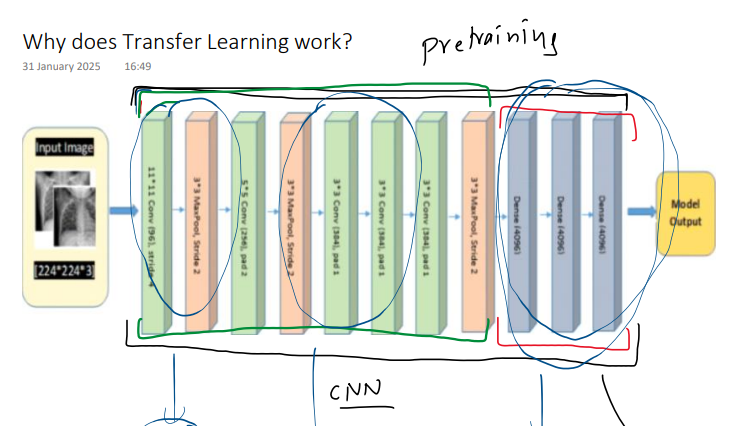


- We train the model on larger data set.
- Now train the model on small data set for `fine_tuning` but in this we only train the fully connected Layer.
- We freeze the Feature Extraction Layers because what we have learned on larger data is not loss.

**Why does it works**

Because in CNN

- starting convolution layers of CNN learns to detect edges
- and the complexity of learning those patterns increase over these convolution layers.

- Any image in the world can be identify with almost those features. Thus this works.


## **How we are going to Use it**

We are going to use VGG16 Model. Which is trained on ImageNet Dataset.


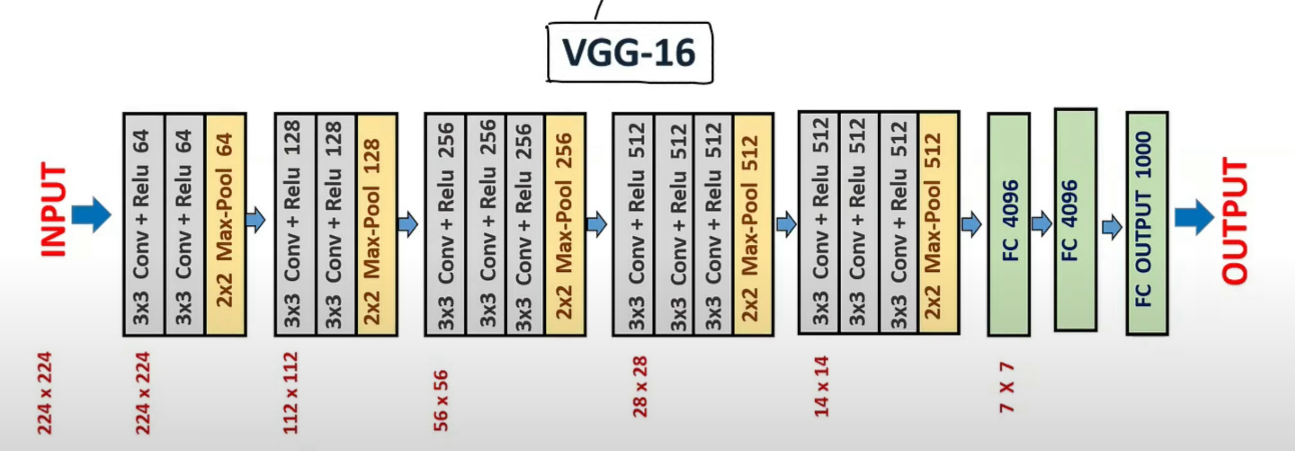


**Feature Extraction:**

4 pairs of Convolution & Pooling


**Classification:**

3 Layers of Fully Connected Layer.


**We will remove the Classifier Part for finetuning**

**Freeze the weight of the Feature Extraction Part**


## **Steps**

1. Load the model
2. Detach classification part
3. Attach our classification Layer
4. Freeze Feature Extraction Layer.
5. Train


**Now the problem is VGG16 is trained on RGB Image but our image is grey scale so we have to perform certain transformation on our images**


The below is the required transformation we needed to perform.

The inference transforms are available at `VGG16_Weights.IMAGENET1K_V1.transforms` and perform the following preprocessing operations:

- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.
- The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].
- Finally the values are first rescaled to [0.0, 1.0] and then normalized using `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225].`


In [164]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [165]:
import warnings

warnings.filterwarnings("ignore")

In [166]:
# Set a manual seed so that anyone running this notebook will have same result
torch.manual_seed(42)

In [167]:
"""
Always check the availability of the GPU
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using the {device}")


Using the cuda


In [168]:
# Read data

df = pd.read_csv("fashion-mnist_train.csv")

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
df.shape

(60000, 785)

So we have 784 features.

One Label


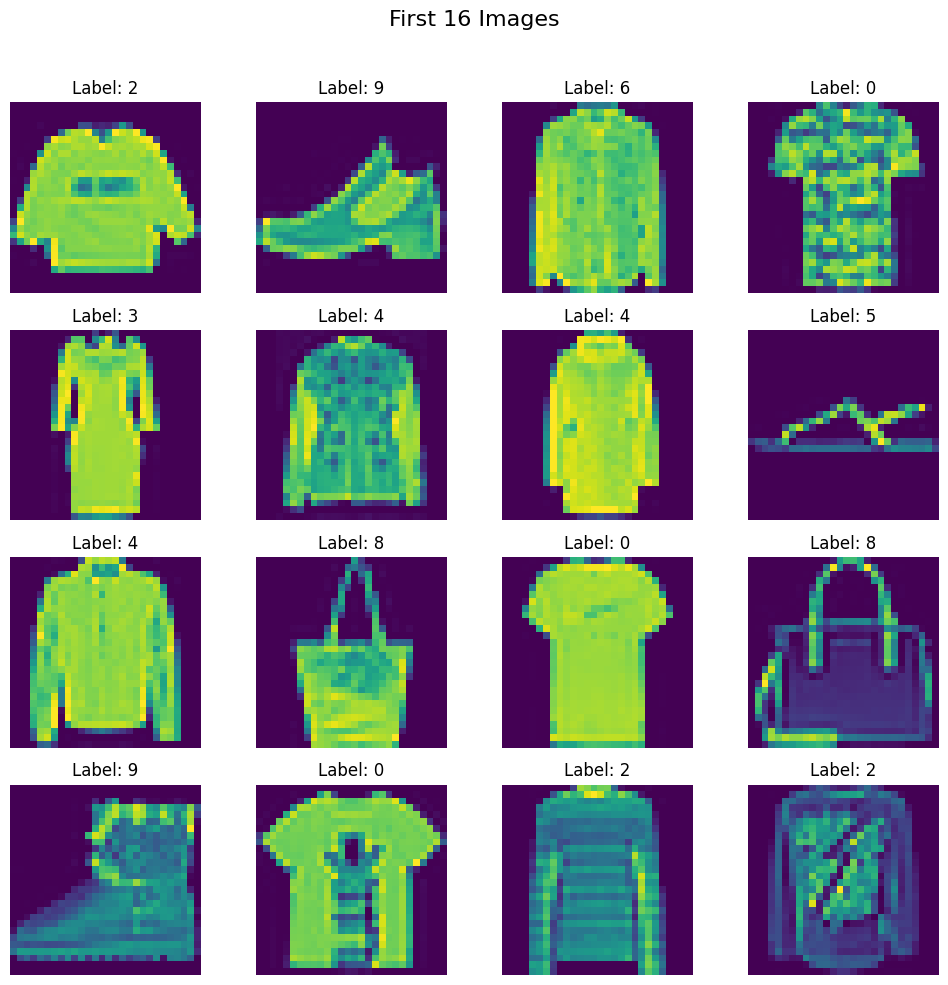

In [170]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis("off")  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [171]:
df["label"].nunique()

10

In [172]:
df["label"].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

So this is a Multiclass Classification Problem we have 10 different Classess.


In [173]:
# x = df.iloc[:,1:]
x = df.iloc[:, 1:].values

In [174]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784))

In [175]:
x.shape

(60000, 784)

In [176]:
# Only label col
y = df.iloc[:, 0].values

In [177]:
y

array([2, 9, 6, ..., 8, 8, 7], shape=(60000,))

In [178]:
y.shape

(60000,)

In [179]:
# Perform the splitting on Data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [180]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], shape=(48000, 784))

In [181]:
x_test

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 211, 102,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(12000, 784))

In [182]:
y_train

array([5, 7, 8, ..., 9, 4, 0], shape=(48000,))

In [183]:
y_test

array([7, 8, 8, ..., 9, 5, 5], shape=(12000,))

## **Data Transformation**

**Conver to PIL Image Before Transformation**

- Our image is in tabular format row(1,784)
- We have to reshape it to 2d i.e(28,28)

- change the datatype of this (28,28) matrix to `np.uint8` because when converting to **PIL** image it accept that format in input.

- 1D to 3D conversion i.e (28,28) --> to (3,28,28).
- Convert this to PIL Image.

**Transformation on PIL Images**

- After getting images following transformation is needed.
- Resize **PIL** image from (3,28,28) to --> (3,256,256).
- After resize we will centre crop it i.e from its centre make it (3,224,224).

- Convert to Tensor & scale so it will be from range(0-1).

- Normalize this using the mean and std of channels given above. I.e Normalize Each Channel Individually.


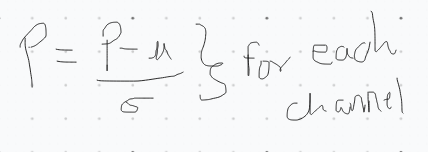


In [184]:
from torchvision.transforms import transforms

"""
We have to define data transformation here.
Mainly
- resize ==> pil to 256x256
- centre crop ==> centre 224x224
- convert to tensor & Scale ==> Tensor and between range(0-1)
- normalize ==>given on pytorch for each channel copy from there
we can simply do it with torch vision.
"""


# in compose we can send multiple transformation
custom_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


## Dataset Class


The main change will be here.
Because currently we are recieving 784 inputs as a single features i.e one Row at a time.

But now we needed an image so we have to reshape those 784 pixels into `28x28 = 784` size image.

Along with that we have to specify the number of channels that means is it greyscale or rgb. Since Our is grescale we have 1.

Along with that we need to specify the batch size, but since we don't know batch_size right now we will replace it with a placeholder as `-1`. This will get adjusted when making data loader.

Replace this.

```python
self.features = torch.tensor(features, dtype=torch.float32)
```

With This

```python
self.features = torch.tensor(features, dtype=torch.float32).reshape(batch_size,channel,width,height)
```


**We have define transformation above**

**We will apply it in our dataset class**


In [185]:
from PIL import Image

In [186]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, transform):
        # We will also recieve transformations to apply on our data
        self.features = torch.tensor(features, dtype=torch.float32).reshape(
            -1, 1, 28, 28
        )
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        """
        before sending item we have to convert it to PIL Images.
        1. Resize
        2. Change data type to uint8
        3. b/w to colour -->change channel size
        4. convert to pil image
        """

        # resize row to (28x28) (convert it to numpy array in order to convert it to uint8)
        image = self.features[index].reshape(28, 28).numpy()

        # change dtype
        image = image.astype(np.uint8)

        # b/w to color (height,weight, channel)
        image = np.stack([image] * 3, axis=-1)

        # array to pil image
        image = Image.fromarray(image)

        """
        Now just apply transformation on the image
        """
        # transformed image
        image = self.transform(image)

        return image, torch.tensor(self.labels[index], dtype=torch.long)

In [187]:
# Stack demo
# THis is (2,2)
# We will make it to (3,2,2)

arr = np.array([[1, 2], [3, 4]])
print(arr)
print("=" * 20)
print(arr.shape)

[[1 2]
 [3 4]]
(2, 2)


In [188]:
arr2 = np.stack([arr] * 3)

print(arr2)
print("=" * 20)
print(arr2.shape)

[[[1 2]
  [3 4]]

 [[1 2]
  [3 4]]

 [[1 2]
  [3 4]]]
(3, 2, 2)


In [189]:
"""But we need the channel at last"""
# This will send the channel at last
arr3 = np.stack([arr] * 3, axis=-1)

print(arr3)
print("=" * 20)
print(arr3.shape)

[[[1 1 1]
  [2 2 2]]

 [[3 3 3]
  [4 4 4]]]
(2, 2, 3)


**Create Datasets**


In [190]:
# train dataset object

train_dataset = CustomDataset(x_train, y_train, transform=custom_transform)

In [191]:
train_dataset

In [192]:
len(train_dataset)

48000

In [193]:
train_dataset.features[0]

tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,  58., 136.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,
            7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,  55.,  80.,
          108., 151., 255.,   0.,   0.,   0.],
     

In [194]:
# Test Dataset

test_dataset = CustomDataset(x_test, y_test, transform=custom_transform)

In [195]:
test_dataset

In [196]:
len(test_dataset)

12000

**DATA LOADER for Batches**


In [197]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

# Because while prediction we dont need shuffling
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [198]:
# total batches
len(train_loader)

1500

## **NEURAL Network**


**WE Dont have to Create our Own Model**

- Fetch the pretrain model


In [199]:
# import model
import torchvision.models as models

# we need weights of pretraining
vgg16 = models.vgg16(pretrained=True)

In [200]:
# See the Model
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [201]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [202]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

**Freeze the Weights of Features**


In [203]:
# Freeze the parameters of features

for param in vgg16.features.parameters():
    # Just set the required grad = False
    # So gradient and update calculation will not be done for these layers.
    param.requires_grad = False

In [204]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

**Now we have to replace the classifier with our model because we dont want all these input and other things**


In [205]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10),
)

In [206]:
# See classifier now
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [207]:
"""
Move the Model to GPU
"""

vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## **Training PipeLine**


**Define Params**


In [208]:
# Parameters
epochs = 10

# it is good that while transfer learning keep the lr slow
learning_rate = 0.0001

In [209]:
# Loss function
criteria = nn.CrossEntropyLoss()

In [210]:
# Optimizer Only for classifier section
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

**Actual training**


In [ ]:
for epoch in range(epochs):
    # just to check all batches loss
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        """
        Move data to gpu
        """
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        outputs = vgg16.forward(batch_features)

        # calculate loss
        loss = criteria(outputs, batch_labels)

        # clear gradient
        optimizer.zero_grad()

        # backprop(calculate gradient)
        loss.backward()

        # update weigths and bias
        optimizer.step()

        # Add to epoch loss just for checking loss of each epoch
        total_epoch_loss += loss

    # Average Loss
    avg_loss = total_epoch_loss / len(train_loader)

    print(f"Epoch:{epoch + 1}, Loss:{avg_loss}")
    print("-" * 30)


Epoch:1, Loss:0.3198179602622986
------------------------------
Epoch:2, Loss:0.1814911663532257
------------------------------
Epoch:3, Loss:0.12467389553785324
------------------------------
Epoch:4, Loss:0.08601217716932297
------------------------------
Epoch:5, Loss:0.06100933626294136
------------------------------
Epoch:6, Loss:0.04557446762919426
------------------------------
Epoch:7, Loss:0.03694276511669159
------------------------------
Epoch:8, Loss:0.028468487784266472
------------------------------
Epoch:9, Loss:0.026861760765314102
------------------------------
Epoch:10, Loss:0.022750521078705788
------------------------------


## **Evaluation**


In [212]:
# Set to Evaluation Mode

vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Evaluation on Testing Data**


In [213]:
# Variables for evaluation
total = 0
correct = 0


with torch.no_grad():
    # Since our testing data is also in batches.

    for batch_features, batch_labels in test_loader:
        """
      Move data to gpu
      """
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # predict on each image
        outputs = vgg16.forward(batch_features)

        # check if it is correct or not
        # See Below Explaination
        # Row wise we need to check for each outputs max value
        # This will return value and index
        idx, v = torch.max(outputs, 1)

        # update total (Add rows)
        total += batch_labels.shape[0]

        # Correct (where predicted is same as batch_label)

        correct = correct + (v == batch_labels).sum()

accuracy = correct / total

print(f"Accuracy:{accuracy}")

Accuracy:0.9228333234786987


**Evaluation on Training Data**


In [214]:
# Variables for evaluation
total = 0
correct = 0


with torch.no_grad():
    # Since our testing data is also in batches.

    for batch_features, batch_labels in train_loader:
        """
      Move data to gpu
      """
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # predict on each image
        outputs = vgg16.forward(batch_features)

        # check if it is correct or not
        # See Below Explaination
        # Row wise we need to check for each outputs max value
        # This will return value and index
        idx, v = torch.max(outputs, 1)

        # update total (Add rows)
        total += batch_labels.shape[0]

        # Correct (where predicted is same as batch_label)

        correct = correct + (v == batch_labels).sum()

accuracy = correct / total

print(f"Accuracy:{accuracy}")

Accuracy:0.9968124628067017


**Without Transfer Learning of CNN**

The Test Accuracy is : `0.922333300113678`

The Training Accuracy is : `0.9998124837875366`


**With Transfer Learning on CNNs**

The Test Accuracy is : `0.9228333234786987`

The Training Accuracy is : `0.9968124628067017`
